In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
from numpy import nan
from constants import *
import sys
import warnings
import math
import os
import cftime
from glob import glob
from timeit import default_timer as timer # try to measure time
from CASutils import readdata_utils as read
from CASutils import calendar_utils as cal
import dask 

In [2]:
importlib.reload(read)
importlib.reload(cal)
warnings.filterwarnings('ignore')

In [45]:
## constants
#paths
pathin = "/net/atmos/data/era5"
#time index
ybegp = 1980 ; monbegp = 1 ; yendp = 2010 ; monendp = 12 ; daybegp = 1 ; dayendp = 31# dates for Past period, only takes 30th 

years = np.arange(ybegp,yendp+1)
months = ["01","02","03","10","11","12"]
#lat lon
latout=np.linspace(-90,90,73)
lonout=np.linspace(0,357.5,144)
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

selvars = ['U10M','V10M']
data_vars = ['PS','MSL','TCC','U10M','V10M','SSTK','CI','D2M','T2M','TCW','TCWV','VIWVD','E',
             'MN2T','MX2T','SI','TTR','TTRC','WG10','LSP','CP','SF','SSHF','SLHF','BLH']
to_drop = ['PS','MSL','TCC','SSTK','CI','D2M','T2M','TCW','TCWV','VIWVD','E',
             'MN2T','MX2T','SI','TTR','TTRC','WG10','LSP','CP','SF','SSHF','SLHF','BLH']


In [46]:
#get pattern
pathlist = []
for yr in years:
    for mn in months:
        pathinvar = pathin+"/"+str(yr)+"/"+mn+'/B'+str(yr)+mn+'??_??'
        pathlist+=glob(pathinvar)
        

data_vars = [dv for dv in ds.data_vars.keys()]

In [58]:
# preprocess
def def_domain(ds,min_lat=30,max_lat=75,min_lon=-30,max_lon=30):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds.sortby(ds.lon)
    LatIndexer, LonIndexer = 'lat', 'lon'
    ds = ds.loc[{LatIndexer: slice(min_lat, max_lat),
                      LonIndexer: slice(min_lon, max_lon)}]
    return ds
def get_ONDJFM_day(ds, months=[1,2,3,10,11,12]):
    if "time" not in ds.dims:
        ds = ds.swap_dims({"day":"time"})   
    return ds.isel(time=ds.time.dt.month.isin(months))

def norm_wind(ds):
    u = ds['U10M']
    v = ds['V10M']
    return np.sqrt(u**2+v**2)

def daily_max(ds):
    return ds.resample(time="1D").max()

def preprocess(ds,**kwargs):
    def def_domain(ds,min_lat=30,max_lat=75,min_lon=-30,max_lon=30):
        ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
        ds.sortby(ds.lon)
        LatIndexer, LonIndexer = 'lat', 'lon'
        ds = ds.loc[{LatIndexer: slice(min_lat, max_lat),
                          LonIndexer: slice(min_lon, max_lon)}]
        return ds
    def get_ONDJFM_day(ds, months=[1,2,3,10,11,12]):
        if "time" not in ds.dims:
            ds = ds.swap_dims({"day":"time"})   
        return ds.isel(time=ds.time.dt.month.isin(months))

    def norm_wind(ds):
        u = ds['U10M']
        v = ds['V10M']
        return np.sqrt(u**2+v**2)
    
    def daily_max(ds):
        return ds.resample(time="1D").max()
    #drop useless var
    #ds = ds[['U10M','V10M']] 
    ds = ds['WG10']
    #slice domain
    ds = def_domain(ds)
    #ds = norm_wind(ds)
    

    # get winter
    #ds = get_ONDJFM_day(ds)
    # daily max
    #ds = daily_max(ds)
    #norm wind
    
    return ds
    


In [48]:
#open data set using mfdataset
start_time = timer()

ds = xr.open_mfdataset(pathlist, concat_dim="time", combine="nested",
                  data_vars='all', coords='minimal', compat='override',preprocess=preprocess,parallel=True)

time_delta_fut = timer() - start_time
print(time_delta_fut)                 

24167.72115666396


In [49]:
start_time = timer()
ds_sort = ds.sortby(ds.time)
ds_day = ds_sort.resample(time="1D").max()
time_delta_fut = timer() - start_time
print(time_delta_fut)   

10824.226235975977


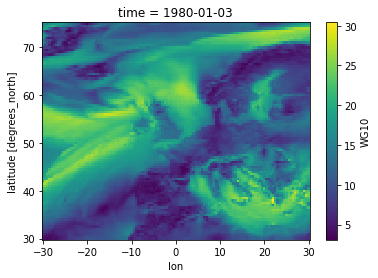

In [50]:
ds_day.isel(time=2).plot()

In [59]:
start_time = timer()
ds_day_winE = get_ONDJFM_day(ds_day)
time_delta_fut = timer() - start_time
print(time_delta_fut)  

0.33201643207576126


In [60]:
ds_day_winE

<xarray.DataArray 'time' (time: 5650)>
array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ..., '2010-12-29T00:00:00.000000000',
       '2010-12-30T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2010-12-31

In [61]:
pathout = '/home/lseverino/MT/era5/'
fn = 'era5_WG10_br_day_EU_winE.nc'
ds_day_winE.to_netcdf(path=pathout+fn)

#v1
start_time = timer()
# this is basically what open_mfdataset does
open_kwargs = dict(decode_cf=True, decode_times=False)
open_tasks = [dask.delayed(xr.open_dataset)(f, **open_kwargs) for f in fn]
tasks = [dask.delayed(preprocess)(task) for task in open_tasks]
datasets = dask.compute(tasks)  # get a list of xarray.Datasets
combined = xr.combine_nested(datasets)  # or some combination of concat, merge
time_delta_fut = timer() - start_time
print(time_delta_fut)

#v2
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

# here we suppose we only care about the combined mean of each file;
# you might also use indexing operations like .sel to subset datasets
start_time = timer()

combined = read_netcdfs(pathinvar, dim='time',
                        transform_func=preprocess)
time_delta_fut = timer() - start_time
print(time_delta_fut)

rs = combined.resample(time="1D").max()

rs.isel(time=8).plot()